# 音声のコンテキストからパラメータを推測する
## 諸々Import (CPUで動くはず)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import time

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers, cuda
xp = cuda.cupy

## コンテキストとパラメータの学習データを読み込む
問題設定: コンテキストの情報からパラメータを予測する

これができると何ができるのか？: 
* 形態素解析などでコンテキストを作成する
* コンテキストからパラメータを推測する←今日ここ
* パラメータから音声を作成する
* うわあああああしゃべったあああああああ
-----
メモ
* コンテキストとは、先行、当該、後続、アクセント句長、アクセント句位置、アクセント型、フレーム数の7次元からなる。
* パラメータとは、基本周波数とメルケプストラムの27次元からなる。
(本来、コンテキストに対してパラメータは可変長になるが、長さの予測は行わず、学習時に対応するフレーム数を導入することで対応関係を取ることにした。)

### 学習・評価データの形式
* [先行, 当該, 後続, アクセント句長, アクセント句位置,　アクセント型, フレーム数,　基本周波数, メルケプストラム[0...25]]
* [phoneme0, phoneme1, phoneme2, accent_len, accent_pos,　accent_type, frame_num,　f0, mcep[0...25]]

### 使ってみるときの形式
* [先行, 当該, 後続, アクセント句長, アクセント句位置,　アクセント型, フレーム数]
* [phoneme0, phoneme1, phoneme2, accent_len, accent_pos,　accent_type, frame_num]

### 使ってみた時に出てくる形式
* [基本周波数, メルケプストラム[0...25]]
* [f0, mcep[0...25]]

### datasディレクトリに諸々入れて使う

In [3]:
# 音素の変換テーブル
#　モデルの読み込みに使う。
with open('onso.pickle', 'rb') as i:
    onso_table = pickle.load(i)
# 学習データとテストデータを読み込む

try:
    contexts_train_csv = pd.read_csv('datas/train.csv', header=None) # ←ここに学習用のテキストデータを渡すと
except FileNotFoundError as e:
    print(e)

test_path = "datas/UEM_091.lab" # ←ここにUEM_091.labを渡すと UEM_091.lab.paramが生成される
try:
    contexts_test_csv = pd.read_csv(test_path, header=None) 
except FileNotFoundError as e:
    print(e)

In [4]:
train_data_len = contexts_train_csv.shape[0]
contexts_train = pd.DataFrame()
contexts_train['phoneme0'] = np.array([onso_table[r] for r in contexts_train_csv[0]])
contexts_train['phoneme1'] = np.array([onso_table[r] for r in contexts_train_csv[1]])
contexts_train['phoneme2'] = np.array([onso_table[r] for r in contexts_train_csv[2]])
contexts_train['accent_len'] = contexts_train_csv[3]/15
contexts_train['accent_pos'] = contexts_train_csv[4]/15
contexts_train['accent_type'] = contexts_train_csv[5]/15
contexts_train['frame_num'] = contexts_train_csv[6]/150
contexts_train['f0'] = np.log(contexts_train_csv[7]+1)
for i in range(26):
    contexts_train['mcep'+str(i)] = contexts_train_csv[8+i]

contexts_train.head()

,phoneme0,phoneme1,phoneme2,accent_len,accent_pos,accent_type,frame_num,f0,mcep0,mcep1,...,mcep16,mcep17,mcep18,mcep19,mcep20,mcep21,mcep22,mcep23,mcep24,mcep25
0,29,14,1,0.133333,0.066667,0.0,0.006667,0.0,-0.648539,0.456265,...,0.019452,0.004019,-0.012505,-0.003931,0.045686,0.116717,-0.151013,-0.115716,-0.163912,-0.080456
1,29,14,1,0.133333,0.066667,0.0,0.013333,0.0,-0.433629,0.324613,...,0.047829,0.130855,-0.063560,0.033953,0.030672,-0.013612,-0.234040,-0.031978,-0.100765,-0.225542
2,29,14,1,0.133333,0.066667,0.0,0.020000,0.0,-0.493183,0.337381,...,0.113755,0.164137,-0.175271,0.068837,0.074774,-0.096105,-0.062341,0.062833,0.002481,-0.156493
3,29,14,1,0.133333,0.066667,0.0,0.026667,0.0,-0.537887,0.220762,...,0.134378,0.168410,-0.067635,0.114970,0.170909,-0.030111,0.040802,-0.067689,-0.100786,-0.049495
4,29,14,1,0.133333,0.066667,0.0,0.033333,0.0,-0.501573,0.188340,...,-0.033314,0.019883,0.075013,0.149588,0.076710,0.116201,0.102792,0.035638,-0.067440,0.040577


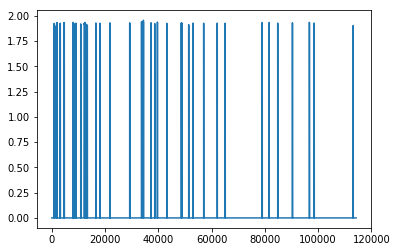

In [4]:
plt.plot(np.log(contexts_train['f0']+1))
plt.show()

In [5]:
test_data_len = contexts_test_csv.shape[0]
contexts_test = pd.DataFrame()
contexts_test['phoneme0'] = np.array([onso_table[r] for r in contexts_test_csv[0]])/30
contexts_test['phoneme1'] = np.array([onso_table[r] for r in contexts_test_csv[1]])/30
contexts_test['phoneme2'] = np.array([onso_table[r] for r in contexts_test_csv[2]])/30
contexts_test['accent_len'] = contexts_test_csv[3]/15
contexts_test['accent_pos'] = contexts_test_csv[4]/15
contexts_test['accent_type'] = contexts_test_csv[5]/15
contexts_test['frame_num'] = contexts_test_csv[6]/150
contexts_test.head()

,phoneme0,phoneme1,phoneme2,accent_len,accent_pos,accent_type,frame_num
0,0.966667,0.166667,0.533333,0.333333,0.066667,0.2,0.006667
1,0.966667,0.166667,0.533333,0.333333,0.066667,0.2,0.013333
2,0.966667,0.166667,0.533333,0.333333,0.066667,0.2,0.020000
3,0.966667,0.166667,0.533333,0.333333,0.066667,0.2,0.026667
4,0.966667,0.166667,0.533333,0.333333,0.066667,0.2,0.033333


## ネットワークを定義する

In [6]:
# Prepare network
# n_inは入力ベクトル長
# n_outは出力ベクトル長
# 良い手段かわからないけど倍ずつ大きくして、最後27次元に落とす
# 一応毎回BatchNormalizationする。
class context2params(chainer.Chain):
    def __init__(self, n_in, n_out):
        super(context2params, self).__init__(
            l1=L.Linear(n_in, 14),
            l2=L.Linear(14, 28),
            l3=L.Linear(28, 56),
            l4=L.Linear(56, n_out),
            bn1 = L.BatchNormalization(14),
            bn2 = L.BatchNormalization(28),
            bn3 = L.BatchNormalization(56),
        )

    def __call__(self, x):
        h1 = F.relu(self.bn1(self.l1(x)))
        h2 = F.relu(self.bn2(self.l2(h1)))
        h3 = F.relu(self.bn3(self.l3(h2)))
        y = self.l4(h3)
        return y

## 学習・評価データセットを切り分ける

In [7]:
# 80%を学習に使って20％を学習の評価に使う。
contexts_train_sample = contexts_train.sample(frac=1)
N = int(len(contexts_train)*0.8)
N_test = len(contexts_train)-N
x_train = contexts_train.iloc[:N, 0:7].values.astype(xp.float32)
x_test = contexts_train.iloc[N:, 0:7].values.astype(xp.float32)
y_train = contexts_train.iloc[:N, 7:].values.astype(xp.float32)
y_test = contexts_train.iloc[N:, 7:].values.astype(xp.float32)

## ネットワークとオプティマイザを定義する

In [8]:
# ネットワーク
model = context2params(7, 27)
gpu_device = 0
cuda.get_device(gpu_device).use()
model.to_gpu(gpu_device)

# 最適化
optimizer = optimizers.Adam()
optimizer.setup(model)

## 学習する

In [ ]:
# 一度に勾配を求めるバッチのサイズ
batchsize = 500
# 学習を行う回数
n_epoch = 100000

start = time.time()
for epoch in range(1, n_epoch + 1):
    # 学習
    # バッチサイズに合わせてランダムに切り出す
    perm = np.random.permutation(N)
    sum_loss = 0
    for i in range(0, N, batchsize):
        # バッチづくり
        x = xp.asarray(x_train[perm[i:i + batchsize]])
        t = xp.asarray(y_train[perm[i:i + batchsize]])

        # 予測
        p = model(x)
        
        # 誤差の計算
        loss = F.mean_squared_error(p, t)

        # 誤差を使って最適化
        model.cleargrads()
        loss.backward()
        optimizer.update()
        # 表示用
        sum_loss += float(loss.data) * batchsize
    train_loss = sum_loss

    # Epoch毎の評価
    sum_loss = 0
    for i in range(0, N_test, batchsize):
        #　バッチづくり
        x = xp.asarray(x_test[i:i + batchsize])
        t = xp.asarray(y_test[i:i + batchsize])
        
        # 予測
        p = model(x)
        
        # 誤差の計算
        loss = F.mean_squared_error(p, t)
        sum_loss += float(loss.data) * batchsize
    test_loss = sum_loss
    
    if epoch % 1000 == 0:
        elapsed_time = time.time() - start
        print ("lean elapsed_time:{0}".format(elapsed_time) + "[sec]")

        print('epoch', epoch)
        print('train mean loss={}'.format(train_loss / N))
        print('test  mean loss={}'.format(test_loss / N_test))
        model.to_cpu()
        # 破壊的なので注意
        with open('datas/context2params_{0:07d}.pickle'.format(epoch), 'wb') as o:
            pickle.dump(model, o)
        model.to_gpu(gpu_device)

epoch 100
train mean loss=24.847913259124674
test  mean loss=12.577761710316084
epoch 200
train mean loss=23.770819652173298
test  mean loss=16.00720233572316
epoch 300
train mean loss=23.331794393994432
test  mean loss=18.414956975229437
epoch 400
train mean loss=23.422317709914182
test  mean loss=19.838232393009577
epoch 500
train mean loss=22.814166543631238
test  mean loss=22.862010248390114
epoch 600
train mean loss=22.256477625780455
test  mean loss=23.847220174646118
epoch 700
train mean loss=22.245688806802946
test  mean loss=24.848305787291896
epoch 800
train mean loss=21.12741128452549
test  mean loss=29.084618519760152
epoch 900
train mean loss=21.898663744768125
test  mean loss=25.91465725162996
epoch 1000
train mean loss=21.96635589642778
test  mean loss=28.690377397596073
epoch 1100
train mean loss=21.628385439136085
test  mean loss=33.4604271771652
epoch 1200
train mean loss=21.65906163380565
test  mean loss=27.908760132836353
epoch 1300
train mean loss=21.18231254269926

## モデルを保存しておく

In [30]:
# GPUで動かしていたらCPUに戻してくる
model.to_cpu()
# 破壊的なので注意
with open('datas/context2params.pickle', 'wb') as o:
    pickle.dump(model, o)

In [31]:
#　モデルの読み込みに使う。
with open('datas/context2params.pickle', 'rb') as i:
    model = pickle.load(i)

In [32]:
# 実際の使い方
# contexts_testからnumpy 配列として読み出してmodelに渡す
x = contexts_test.values.astype(xp.float32)
# modelの返り値はVariable型になっているので.dataでnumpy.array型に戻す。
pred = pd.DataFrame(model(x).data, dtype=xp.float32)

# 音声生成が使いやすい形式のファイルに書き出す
# CSV
pred.to_csv(test_path+'.param', index=False)

In [ ]:
x = xp.array([[0 for i in range(7)]], dtype=xp.float32)
plt.bar(range(27), model(x).data[0])
plt.show()

## 最初は持ってないから疑似学習・評価データを作る

In [ ]:
# 疑似データ生成
train_data_len = 50
np.random.seed(0)
contexts_train = pd.DataFrame()
contexts_train['phoneme0'] = np.random.randint(0,20, size = train_data_len)
contexts_train['phoneme1'] = np.random.randint(0,20, size = train_data_len)
contexts_train['phoneme2'] = np.random.randint(0,20, size = train_data_len)
contexts_train['accent_len'] = np.random.randint(0,20, size = train_data_len)
contexts_train['accent_pos'] = np.random.randint(0,20, size = train_data_len)
contexts_train['accent_type'] = np.random.randint(0,20, size = train_data_len)
contexts_train['frame_num'] = np.random.randint(0,20, size = train_data_len)
contexts_train['f0'] = np.random.rand(train_data_len)
for i in range(26):
    contexts_train['mcep'+str(i)] = np.random.rand(train_data_len)

contexts_train.head()


## 最初は持ってないから疑似テストデータを作る

In [ ]:
test_data_len = 1000
contexts_test = pd.DataFrame()
contexts_test['phoneme0'] = np.random.randint(0,20, size = test_data_len)
contexts_test['phoneme1'] = np.random.randint(0,20, size = test_data_len)
contexts_test['phoneme2'] = np.random.randint(0,20, size = test_data_len)
contexts_test['accent_len'] = np.random.randint(0,20, size = test_data_len)
contexts_test['accent_pos'] = np.random.randint(0,20, size = test_data_len)
contexts_test['accent_type'] = np.random.randint(0,20, size = test_data_len)
contexts_test['frame_num'] = np.random.randint(0,20, size = test_data_len)

contexts_test.head()